# PREPROCESSING

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#
data_2020 = pd.read_csv('valeursfoncieres-2020.txt',sep='|')

data_2019 = pd.read_csv('valeursfoncieres-2019.txt',sep='|')
data_2018 = pd.read_csv('valeursfoncieres-2018.txt',sep='|')
data_2017 = pd.read_csv('valeursfoncieres-2017.txt',sep='|')


C:\Users\Pirlouit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (14,18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Pirlouit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Pirlouit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,23,24,26,28,29,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [33]:
df_2020 = data_2020.copy()
df_2019 = data_2019.copy()
df_2018 = data_2018.copy()
df_2017 = data_2017.copy()


In [34]:
df = pd.concat([df_2017,df_2018,df_2019,df_2020],axis=0)

In [35]:
df.shape

(12314471, 43)

In [36]:
def feature_selection(df): #on regroupe toutes les modifications qu'on fait sur le dataset dans une fonction preprocessing 
   # df = df[df['Commune']=='LILLE'] #on ne garde que les valeurs pour Lille ici
    df = df[df['Code departement']==59]

    df = df[df['Nature mutation']=='Vente']
    df = df[df['Nature mutation'].isna()==False] #on ne garde que les mutations de type vente ou vente en l'état futur d'achevement
    df = df[df['Surface reelle bati'].isna()==False] 
    df = df[df['Surface reelle bati']!=0] #on supprime les colonnes ou la surface bati est 0
    df = df[df['Surface terrain']!=0] #on supprime les colonnes ou la surface bati est 0
    df = df[df['Nombre pieces principales'].isna()==False] 
    df = df[df['Type local'].isna()==False] 
    df = df[df['Type de voie'].isna()==False] 
    df = df[df['Valeur fonciere'].isna()==False] 
    df = df[df['Nombre de lots']<2]
    df = df.drop('Surface Carrez du 1er lot',axis=1)
    df = df.drop('Surface terrain',axis=1)
    df = df.drop('Nature culture',axis=1)
    df = df.drop('1er lot',axis=1)
    df = df.drop('No disposition',axis=1)




        
    df = df[df['Surface reelle bati']<320]
    df = df[df['Type local']!='Local industriel. commercial ou assimilé']
    df = df[df['Type local']!='Maison'] #on ne garde que les appartements pour finir
    df = df[df.columns[(df.isna().sum()/df.shape[0] < 0.80)]] #on supprime les colonnes qui ont plus de 80% de manquants
    df = df.dropna(axis=0)
    df['Valeur fonciere'] = df['Valeur fonciere'].str.replace(',','.')
    df['Valeur fonciere']=pd.to_numeric(df['Valeur fonciere'], errors='coerce')    
    df = df[df['Valeur fonciere']<1000000] #on supprime les biens dont la valeur est supérieure à 1 millions (outliers)
    df = df[df['Valeur fonciere']>100000] #on supprime les biens dont la valeur est inferieure a 100k (outliers)
    df = df.drop('No voie',axis=1) #numero de la maison inutile pour faire une prediction cela pourrait fausser le modele
    df = df.drop('Code departement',axis=1) #tous dans le même departement pour l'instant donc inutile, a voir pour la suite
    #on va provisoirement dropper les donnees en dessous, on va les encoder par la suite
   # df = df.drop('Commune',axis=1) #pareil, pour l'instant on travaille que sur Lille
    df = df.drop('Code commune',axis=1) #plusieurs villes avec le meme code commune, on va encoder nous-mêmes les villes
    df = df.drop('Type local',axis=1) #pas besoin car on a seulement gardé les appartements
    df = df.drop('Code type local',axis=1) 
    df = df.drop('Nature mutation',axis=1) #pareil, on a seulement gardé les type 'Vente'
    df = df.drop('Nombre de lots',axis=1) #on a garde seulement nombre de lots égal à 0 ou 1 donc pas besoin de cette variable
  #  df = df.drop('Voie',axis=1) #il faut encoder cette valeur pour l'utiliser (cest le nom de la rue donc tres important)

    
    df = df.drop('Section',axis=1) #pas pratique pour l'utilisateur de devoir entrer la section mais important pour localiser l'appart
  #  df = df.drop('Type de voie',axis=1) 
    df = df.drop('No plan',axis=1)
    
    df = df.drop('Code voie',axis=1) #on a deja la variable Voie
   # df = df.drop('Date mutation',axis=1) 
    return df
    
df = feature_selection(df)

In [37]:

df.shape 

(27979, 8)

In [ ]:
[df['Commune_0'].value_counts()]

<AxesSubplot:xlabel='Type de voie', ylabel='Valeur fonciere'>

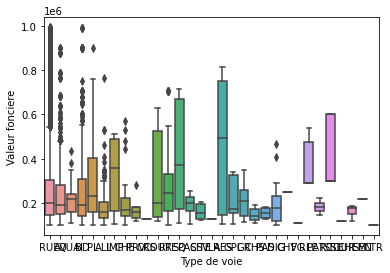

In [13]:
sns.boxplot(x="Type de voie", y="Valeur fonciere", data=df)


In [14]:
df['Date mutation'].value_counts()

21/12/2018    237
28/12/2018    112
29/03/2019    105
27/09/2019     85
30/09/2019     82
             ... 
13/10/2018      1
05/05/2018      1
15/06/2019      1
12/10/2019      1
23/02/2019      1
Name: Date mutation, Length: 559, dtype: int64

# On va encoder nos données    

In [717]:
# D'abord on va ajouter dans la colonne Voie le nom de la ville pour ne pas avoir le même encodage
# pour deux rues du meme noms dans deux villes differentes

In [38]:
df['Voie'] = df['Voie']+'_'+df['Commune']
df['Voie']

1909144      NICOLAS LEBLANC_LILLE
1909164           DU MAGASIN_LILLE
1909171     FAIDHERBE_LA MADELEINE
1909173    DE FLANDRE_LA MADELEINE
1909175      DU PEUPLE BELGE_LILLE
                    ...           
1453511       PASTEUR_VALENCIENNES
1453512       PASTEUR_VALENCIENNES
1453513       PASTEUR_VALENCIENNES
1453514       PASTEUR_VALENCIENNES
1453515       PASTEUR_VALENCIENNES
Name: Voie, Length: 27979, dtype: object

In [581]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
onehotencoder = OneHotEncoder(sparse=False)

#encodage onehot sur les voies
encoded = onehotencoder.fit_transform(df['Voie'].values.reshape(df['Voie'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Voie_' + str(int(i)) for i in range(encoded.shape[1])] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Voie',axis=1) 
df
#il faut reindexer les elements de df de 0 a 2626 

,Date mutation,Valeur fonciere,Type de voie,Code postal,Commune,Surface reelle bati,Nombre pieces principales,Voie_0,Voie_1,Voie_2,...,Voie_1742,Voie_1743,Voie_1744,Voie_1745,Voie_1746,Voie_1747,Voie_1748,Voie_1749,Voie_1750,Voie_1751
0,02/01/2018,167900.0,RUE,59000.0,LILLE,54.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,03/01/2018,121240.0,AV,59110.0,LA MADELEINE,47.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,05/01/2018,173800.0,RUE,59110.0,LA MADELEINE,50.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,02/01/2018,167500.0,RUE,59260.0,LILLE,55.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,02/01/2018,167500.0,RUE,59260.0,LILLE,20.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14346,20/12/2019,220000.0,RUE,59300.0,VALENCIENNES,17.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14347,20/12/2019,220000.0,RUE,59300.0,VALENCIENNES,18.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14348,20/12/2019,319000.0,RUE,59300.0,VALENCIENNES,74.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14349,20/12/2019,319000.0,RUE,59300.0,VALENCIENNES,49.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
from sklearn.preprocessing import OrdinalEncoder
#encodage en ordinal sur les voies
ordinalencoder = OrdinalEncoder()
encoded = ordinalencoder.fit_transform(df['Voie'].values.reshape(df['Voie'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Voie_' + str(int(i)) for i in range(encoded.shape[1])] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Voie',axis=1) 
df

,Date mutation,Valeur fonciere,Type de voie,Code postal,Commune,Surface reelle bati,Nombre pieces principales,Voie_0
0,05/01/2017,170200.0,RUE,59000.0,LILLE,49.0,2.0,2926.0
1,12/01/2017,219500.0,RUE,59800.0,LILLE,84.0,3.0,1774.0
2,05/01/2017,115000.0,RUE,59110.0,LA MADELEINE,49.0,2.0,2083.0
3,05/01/2017,135000.0,RUE,59110.0,LA MADELEINE,88.0,4.0,565.0
4,09/01/2017,230000.0,AV,59800.0,LILLE,73.0,4.0,1890.0
...,...,...,...,...,...,...,...,...
27974,29/12/2020,216835.0,RUE,59300.0,VALENCIENNES,18.0,1.0,2984.0
27975,29/12/2020,216835.0,RUE,59300.0,VALENCIENNES,13.0,1.0,2984.0
27976,29/12/2020,216835.0,RUE,59300.0,VALENCIENNES,34.0,2.0,2984.0
27977,29/12/2020,216835.0,RUE,59300.0,VALENCIENNES,16.0,1.0,2984.0


In [582]:
#encodage onehot sur les types de voie
encoded = onehotencoder.fit_transform(df['Type de voie'].values.reshape(df['Type de voie'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Type de voie_' + str(int(i)) for i in range(encoded.shape[1])] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Type de voie',axis=1) 
df

,Date mutation,Valeur fonciere,Code postal,Commune,Surface reelle bati,Nombre pieces principales,Voie_0,Voie_1,Voie_2,Voie_3,...,Type de voie_21,Type de voie_22,Type de voie_23,Type de voie_24,Type de voie_25,Type de voie_26,Type de voie_27,Type de voie_28,Type de voie_29,Type de voie_30
0,02/01/2018,167900.0,59000.0,LILLE,54.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,03/01/2018,121240.0,59110.0,LA MADELEINE,47.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,05/01/2018,173800.0,59110.0,LA MADELEINE,50.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,02/01/2018,167500.0,59260.0,LILLE,55.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,02/01/2018,167500.0,59260.0,LILLE,20.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14346,20/12/2019,220000.0,59300.0,VALENCIENNES,17.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14347,20/12/2019,220000.0,59300.0,VALENCIENNES,18.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14348,20/12/2019,319000.0,59300.0,VALENCIENNES,74.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14349,20/12/2019,319000.0,59300.0,VALENCIENNES,49.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#encodage en ordinal sur les types de voie
ordinalencoder = OrdinalEncoder()
encoded = ordinalencoder.fit_transform(df['Type de voie'].values.reshape(df['Type de voie'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Type de voie_' + str(int(i)) for i in range(encoded.shape[1])] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Type de voie',axis=1) 
df

,Date mutation,Valeur fonciere,Code postal,Commune,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0
0,05/01/2017,170200.0,59000.0,LILLE,49.0,2.0,2926.0,29.0
1,12/01/2017,219500.0,59800.0,LILLE,84.0,3.0,1774.0,29.0
2,05/01/2017,115000.0,59110.0,LA MADELEINE,49.0,2.0,2083.0,29.0
3,05/01/2017,135000.0,59110.0,LA MADELEINE,88.0,4.0,565.0,29.0
4,09/01/2017,230000.0,59800.0,LILLE,73.0,4.0,1890.0,1.0
...,...,...,...,...,...,...,...,...
27974,29/12/2020,216835.0,59300.0,VALENCIENNES,18.0,1.0,2984.0,29.0
27975,29/12/2020,216835.0,59300.0,VALENCIENNES,13.0,1.0,2984.0,29.0
27976,29/12/2020,216835.0,59300.0,VALENCIENNES,34.0,2.0,2984.0,29.0
27977,29/12/2020,216835.0,59300.0,VALENCIENNES,16.0,1.0,2984.0,29.0


In [41]:
#encodage de la date
#on cree une colonne 'mois' a partir de la colonne date
df['Mois'] = 0
df['Annee'] = 0
for i in range(df.shape[0]):
    df['Mois'][i] = int((df['Date mutation'][i])[3:5])
    df['Annee'][i] = int((df['Date mutation'][i])[6:10])
df = df.drop('Date mutation',axis=1) 
df

<ipython-input-41-a794c796b21e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mois'][i] = int((df['Date mutation'][i])[3:5])
<ipython-input-41-a794c796b21e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Annee'][i] = int((df['Date mutation'][i])[6:10])


,Valeur fonciere,Code postal,Commune,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee
0,170200.0,59000.0,LILLE,49.0,2.0,2926.0,29.0,1,2017
1,219500.0,59800.0,LILLE,84.0,3.0,1774.0,29.0,1,2017
2,115000.0,59110.0,LA MADELEINE,49.0,2.0,2083.0,29.0,1,2017
3,135000.0,59110.0,LA MADELEINE,88.0,4.0,565.0,29.0,1,2017
4,230000.0,59800.0,LILLE,73.0,4.0,1890.0,1.0,1,2017
...,...,...,...,...,...,...,...,...,...
27974,216835.0,59300.0,VALENCIENNES,18.0,1.0,2984.0,29.0,12,2020
27975,216835.0,59300.0,VALENCIENNES,13.0,1.0,2984.0,29.0,12,2020
27976,216835.0,59300.0,VALENCIENNES,34.0,2.0,2984.0,29.0,12,2020
27977,216835.0,59300.0,VALENCIENNES,16.0,1.0,2984.0,29.0,12,2020


In [42]:
#encodage en ordinal
ordinalencoder = OrdinalEncoder()
encoded = ordinalencoder.fit_transform(df['Commune'].values.reshape(df['Commune'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Commune_' + str(int(i)) for i in range(encoded.shape[1])] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Commune',axis=1) 
df

,Valeur fonciere,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0
0,170200.0,59000.0,49.0,2.0,2926.0,29.0,1,2017,159.0
1,219500.0,59800.0,84.0,3.0,1774.0,29.0,1,2017,159.0
2,115000.0,59110.0,49.0,2.0,2083.0,29.0,1,2017,138.0
3,135000.0,59110.0,88.0,4.0,565.0,29.0,1,2017,138.0
4,230000.0,59800.0,73.0,4.0,1890.0,1.0,1,2017,159.0
...,...,...,...,...,...,...,...,...,...
27974,216835.0,59300.0,18.0,1.0,2984.0,29.0,12,2020,269.0
27975,216835.0,59300.0,13.0,1.0,2984.0,29.0,12,2020,269.0
27976,216835.0,59300.0,34.0,2.0,2984.0,29.0,12,2020,269.0
27977,216835.0,59300.0,16.0,1.0,2984.0,29.0,12,2020,269.0


In [652]:
#encodage onehot sur les communes
encoded = onehotencoder.fit_transform(df['Commune'].values.reshape(df['Commune'].shape[0],1))
encoded_df = pd.DataFrame(encoded,columns = ['Commune_' + str(int(i)) for i in range(encoded.shape[1])] ) 
df=df.reset_index(drop=True)
df = pd.concat([df,encoded_df],axis=1)
df = df.drop('Commune',axis=1) 
df

,Valeur fonciere,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0,Commune_1,...,Commune_219,Commune_220,Commune_221,Commune_222,Commune_223,Commune_224,Commune_225,Commune_226,Commune_227,Commune_228
0,167900.0,59000.0,54.0,2.0,262.0,25.0,1,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,121240.0,59110.0,47.0,2.0,18.0,1.0,1,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,173800.0,59110.0,50.0,2.0,1536.0,25.0,1,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,167500.0,59260.0,55.0,3.0,888.0,25.0,1,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,167500.0,59260.0,20.0,1.0,888.0,25.0,1,2018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14346,220000.0,59300.0,17.0,1.0,377.0,25.0,12,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14347,220000.0,59300.0,18.0,1.0,377.0,25.0,12,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14348,319000.0,59300.0,74.0,3.0,1078.0,25.0,12,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14349,319000.0,59300.0,49.0,2.0,1078.0,25.0,12,2019,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
df['Annee'].value_counts()

2019    7513
2018    6838
Name: Annee, dtype: int64

In [12]:
from scipy import stats
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] #pour filtrer les outliers selon le score Z(calculer avec moyenne et ecart type)


In [43]:
df = df[(np.abs(stats.zscore(df)) < 2.5).all(axis=1)] #pour filtrer les outliers selon le score Z(calculer avec moyenne et ecart type)


In [44]:
df

,Valeur fonciere,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0
0,170200.0,59000.0,49.0,2.0,2926.0,29.0,1,2017,159.0
1,219500.0,59800.0,84.0,3.0,1774.0,29.0,1,2017,159.0
2,115000.0,59110.0,49.0,2.0,2083.0,29.0,1,2017,138.0
3,135000.0,59110.0,88.0,4.0,565.0,29.0,1,2017,138.0
4,230000.0,59800.0,73.0,4.0,1890.0,1.0,1,2017,159.0
...,...,...,...,...,...,...,...,...,...
27974,216835.0,59300.0,18.0,1.0,2984.0,29.0,12,2020,269.0
27975,216835.0,59300.0,13.0,1.0,2984.0,29.0,12,2020,269.0
27976,216835.0,59300.0,34.0,2.0,2984.0,29.0,12,2020,269.0
27977,216835.0,59300.0,16.0,1.0,2984.0,29.0,12,2020,269.0


 # Création d'un premier modèle : Prix d'un appartement

In [15]:
from sklearn.model_selection import train_test_split

In [45]:
trainset, testset = train_test_split(df,test_size=0.2,random_state=0)

In [46]:
y_test = testset['Valeur fonciere']
y_train = trainset['Valeur fonciere']

X_test = testset.drop('Valeur fonciere',axis=1)
X_train = trainset.drop('Valeur fonciere',axis=1)


In [47]:
X_test

,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0
19751,59129.0,32.0,3.0,3175.0,29.0,3,2019,19.0
20769,59800.0,80.0,3.0,144.0,29.0,1,2020,159.0
22817,59800.0,61.0,3.0,841.0,29.0,10,2020,159.0
1581,59000.0,29.0,2.0,2164.0,29.0,7,2017,159.0
6758,59000.0,12.0,1.0,885.0,29.0,3,2018,159.0
...,...,...,...,...,...,...,...,...
14083,59800.0,56.0,2.0,3258.0,29.0,5,2019,159.0
743,59800.0,44.0,2.0,1401.0,29.0,4,2017,159.0
26195,59270.0,50.0,2.0,2006.0,29.0,10,2020,21.0
1160,59000.0,15.0,1.0,3380.0,2.0,6,2017,159.0


<AxesSubplot:>

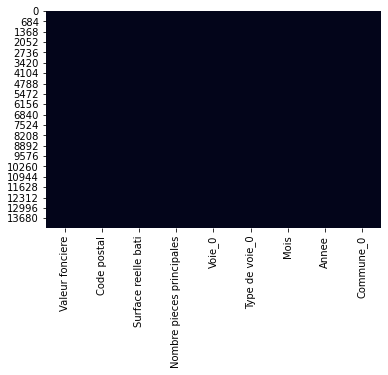

In [288]:
sns.heatmap(df.isna(),cbar=False)

In [195]:
df.isna().sum()

No disposition               0
Valeur fonciere              0
Code postal                  0
Commune                      0
Surface reelle bati          0
Nombre pieces principales    0
Voie_0                       0
Type de voie_0               0
Mois                         0
Annee                        0
dtype: int64

In [686]:
df['No disposition'].value_counts()

1    14142
2      187
3       16
5        6
Name: No disposition, dtype: int64

In [169]:
type(df)

pandas.core.frame.DataFrame

onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
M = onehotencoder.fit_transform(df['Voie'].values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(M, columns = ["Voie_"+str(int(i)) for i in range(df.shape[i])]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['Voie'], axis=1) 
#printing to verify 
print(df.head())

In [19]:
from sklearn.ensemble import RandomForestRegressor


In [20]:
model = RandomForestRegressor(n_estimators=100,random_state=0)


In [21]:
model.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

In [22]:
model.feature_importances_[model.feature_importances_ > 0.1]

array([0.10827486, 0.17447546, 0.31513048, 0.1430311 , 0.11780595])

In [23]:
y_pred = model.predict(X_test)


In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse
#rmse de 124k avec les rues(en ordinal), dates et type de voie
#rmse de 98k avec le 59, encodage ordinal sur les rues et onehot sur les types de voie, n_esti=100
#rmse de 95k avec le 59, encodage onehot sur les rues et onehot sur les types de voie, n_esti=100

83010.03949528969

Cherchons à interpréter le RMSE ici

In [208]:
y_test.mean()

262748.76119070686

In [209]:
#on affiche le pourcentage d'erreur moyen en prenant la moyenne des predictions et la moyenne des valeurs attendues (un rmse seul ne veut pas dire grand chose)
(rmse/y_test.mean()) * 100
#on avait 65% au depart 
#42% apres avoir ajoute les rues !! (encodees en onehot)
#38% avec tout le 59

37.17853502645564

# On compare avec un modele Bridge qui n a pas l air beaucoup plus efficace on va comparer les learning curve

In [36]:
from sklearn.linear_model import Ridge

In [37]:
model_2 = Ridge(alpha=1)

In [38]:
model_2.fit(X_train,y_train)

Ridge(alpha=1)

In [39]:
y_pred = model_2.predict(X_test)


In [40]:
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

172358.17825228226

In [41]:
y_test.mean()

259710.46393242775

In [42]:
(rmse/y_test.mean()) * 100


66.36551167115351

# On va essayer un modele de regression lineaire cette fois

In [381]:
from sklearn.linear_model import LinearRegression

In [295]:
model_3 = LinearRegression()

In [296]:
model_3.fit(X_train,y_train)
y_pred = model_3.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

180080.0743116637

In [297]:
(rmse/y_test.mean()) * 100
#66% c'est beaucoup moins bon que le modele de RandomForest

68.00513902433734

In [28]:
from sklearn.model_selection import learning_curve

In [223]:
N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))

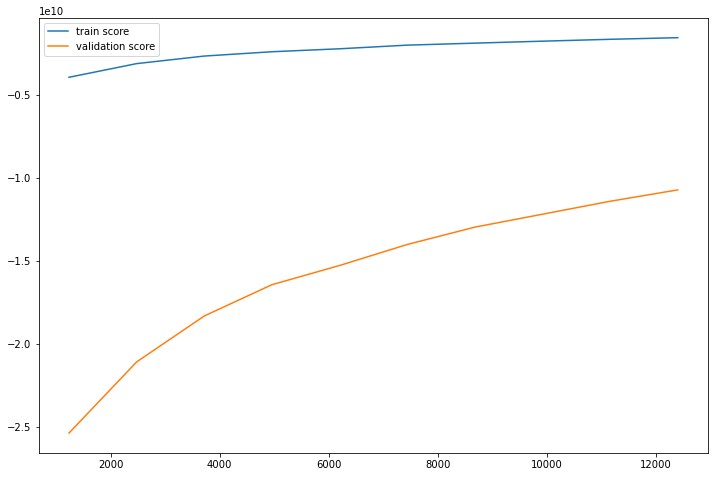

In [224]:
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()
    

In [480]:

#Courbe apprentissage pour le Bridge
N, train_score, val_score = learning_curve(model_2, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))

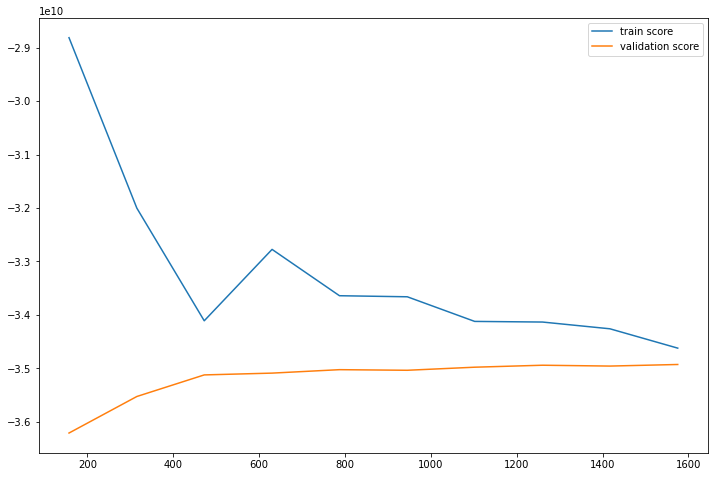

In [481]:
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()
#Au vu de la courbe on va abandonner le modele de Bridge qui semble peu prometteur

In [49]:
#Courbe apprentissage pour le LinearRegression
N, train_score, val_score = learning_curve(model_3, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))

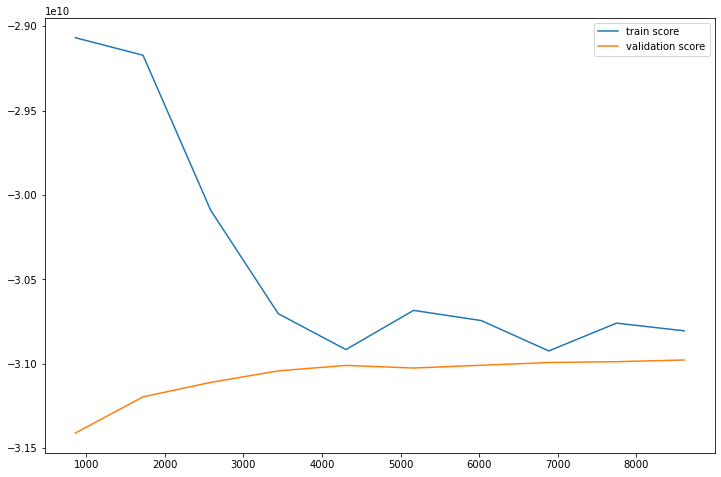

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()
    

# Idees

 - Filtrer les communes pour garder seulement celles qui apparaissent plus de 10 fois 
 - Importer les données des autres années et créer une colonne année -> ok
 - Optimiser les hyper-parametres avec GridSearchCV -> on obtient pas mieux que 75k de rmse malgré l'optimisation rapide des parametres, a continuer
 - Prendre les donnees de toute la région pas seulement Lille? -> meilleur resultat !
 

# Optimisation du modele

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [226]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [105]:
RandomForest = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))


In [356]:
hyper_params = {'randomforestregressor__n_estimators': [500,1000,1500,2000],
                'randomforestregressor__max_features': ['sqrt'], 
                #'randomforestregressor__max_depth' : range(10,300),
                'randomforestregressor__min_samples_split' : range(2,50),
                'randomforestregressor__min_samples_leaf' : range(2,10),
                #'randomforestregressor__max_leaf_nodes' : range(5,500),
               'pipeline__polynomialfeatures__degree': [2,3],
               'pipeline__selectkbest__k': range(6,15)
               } 

                

In [357]:
grid = RandomizedSearchCV(RandomForest, hyper_params, scoring='neg_mean_squared_error', cv=2,
                          n_iter=5)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)



{'randomforestregressor__n_estimators': 1500, 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__max_features': 'sqrt', 'pipeline__selectkbest__k': 8, 'pipeline__polynomialfeatures__degree': 2}


In [358]:
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

102400.45806572305

In [118]:
model_f = grid #on garde le meilleur modele qu'on a pour le moment

In [236]:
model

RandomForestRegressor(random_state=0)

In [61]:
from sklearn.metrics import SCORERS

In [62]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [71]:
RandomForest.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'randomforestregressor', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__polynomialfeatures', 'pipeline__selectkbest', 'pipeline__polynomialfeatures__degree', 'pipeline__polynomialfeatures__include_bias', 'pipeline__polynomialfeatures__interaction_only', 'pipeline__polynomialfeatures__order', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 

{'randomforestregressor__n_estimators': 300, 'randomforestregressor__max_features': 'log2', 'pipeline__selectkbest__k': 6, 'pipeline__polynomialfeatures__degree': 1}
78523.01169128284
{'randomforestregressor__n_estimators': 1000, 'randomforestregressor__max_features': 'sqrt', 'pipeline__selectkbest__k': 7, 'pipeline__polynomialfeatures__degree': 2}
75885.78347177772

In [35]:
preprocessor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_classif, k=7))
model_f = make_pipeline(preprocessor, RandomForestRegressor(random_state=0,n_estimators=90,max_features='sqrt',min_samples_split=3,max_depth=26 ) )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

69095.03336081469

In [36]:
(rmse/y_test.mean()) * 100


28.827079365323343

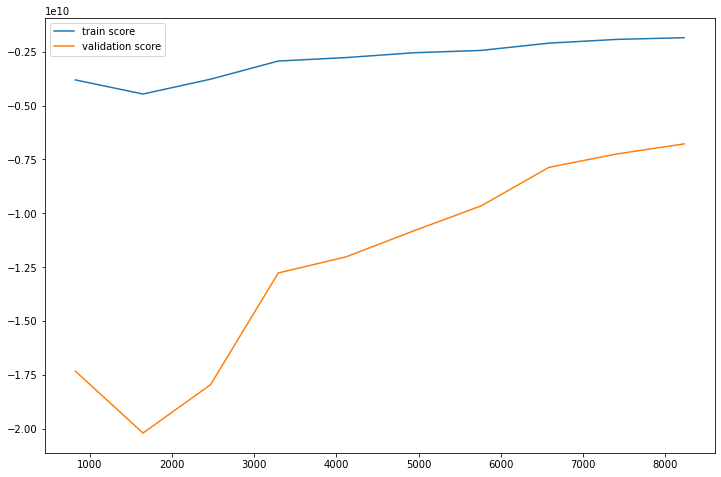

In [38]:
N, train_score, val_score = learning_curve(model_f, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()


On arrive pas a avoir un modele avec un rmse mieux que 75k ce qui est pas mal mais pas assez bon, on va alors essayer d'optimiser un modele de regressionlineaire

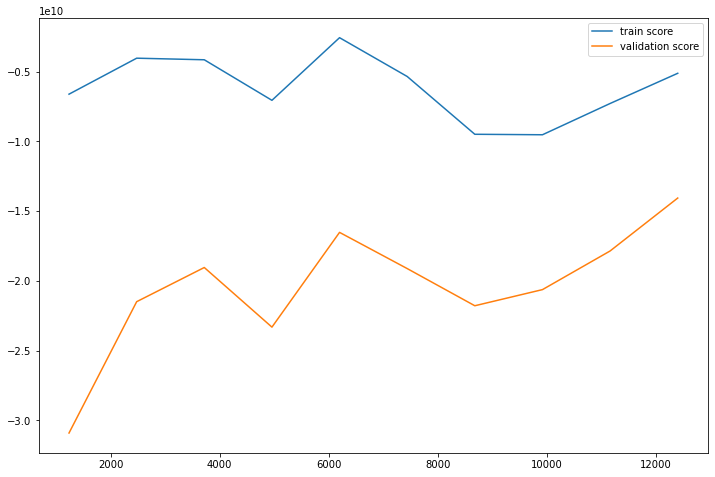

In [213]:
N, train_score, val_score = learning_curve(model_f, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()
    

# Optimisation du modele LinearRegression

In [382]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))
LinearRegr = make_pipeline(preprocessor,StandardScaler(), LinearRegression())



In [373]:
hyper_params = {'linearregression__normalize' : [True,False],
               'pipeline__polynomialfeatures__degree': range(10),
               'pipeline__selectkbest__k': range(6,15)
               } 

In [374]:
grid = RandomizedSearchCV(LinearRegr, hyper_params, scoring='neg_mean_squared_error', cv=4,
                          n_iter=5)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)



{'pipeline__selectkbest__k': 12, 'pipeline__polynomialfeatures__degree': 2, 'linearregression__normalize': True}


In [375]:
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

173975.19171605585

In [ ]:
preprocessor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False) )
model_f = make_pipeline(preprocessor,StandardScaler(), LinearRegression() )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

In [ ]:
model_f.predict()

In [413]:
y_test

663      700000.0
3019     266000.0
10688    115000.0
11953    280000.0
9770     170900.0
           ...   
7953     203275.0
8606     127000.0
6848     240000.0
1351     117000.0
6491     115000.0
Name: Valeur fonciere, Length: 2871, dtype: float64

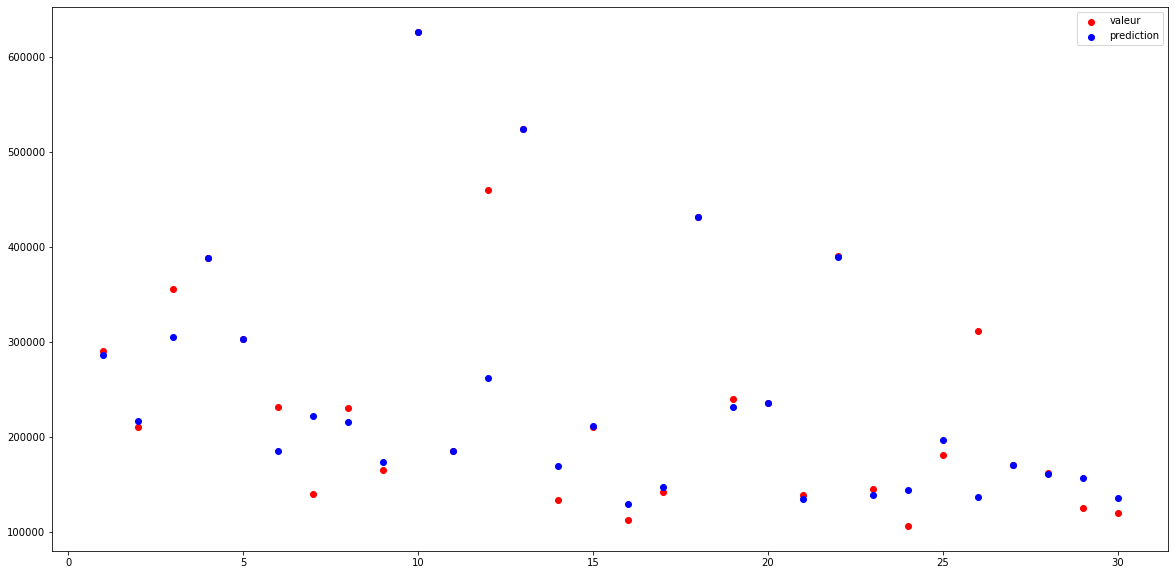

In [109]:
plt.figure(figsize=(20,10))

plt.scatter(x=np.linspace(1,30,30),y=y_test[20:50],label='valeur',c='r')
plt.scatter(x=np.linspace(1,30,30),y=y_pred[20:50],label='prediction',c='b')
plt.legend()

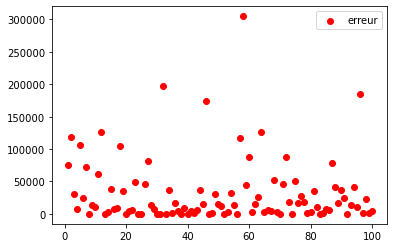

In [110]:
plt.scatter(x=np.linspace(1,100,100),y=abs(y_test[:100]-y_pred[:100]),label='erreur',c='r')
plt.legend()

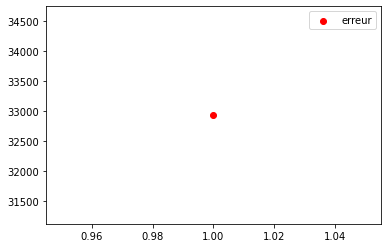

In [608]:
plt.scatter(x=np.linspace(1,1,1),y=abs(y_test[96:97]-y_pred[96:97]),label='erreur',c='r')
plt.legend()
#on voit que la valeur a l index 97 a une erreur de quasi 500k ce qui est enorme, on va essayer de la visualier pour comprendre d'ou vient cet ecart

In [610]:
X_test[96:97]

,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0
7063,59800.0,12.0,1.0,276.0,25.0,1,2019,124.0


In [461]:
y_test[96:97]

10023    695000.0
Name: Valeur fonciere, dtype: float64

In [462]:
y_pred[96:97]

array([210819.35628558])

- Recuperer les donnees ou le modele se trompe beaucoup pour essayer de comprendre pourquoi
- Retirer les outliers

In [467]:
df[df['Type de voie_0']==25]['Valeur fonciere'].mean()

261785.41288591805

In [468]:
df['Valeur fonciere'].mean()

262120.18909971448

On constate que l'écart ne semble pas venir du type de voie, on continue nos recherches

In [485]:
df[df['Code postal']==59100]['Valeur fonciere'].mean()

258298.89574155654

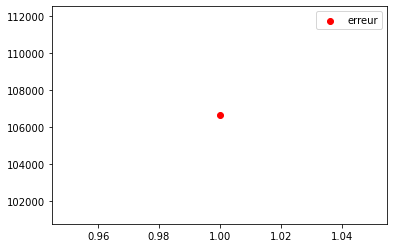

In [611]:
plt.scatter(x=np.linspace(1,1,1),y=abs(y_test[99:100]-y_pred[99:100]),label='erreur',c='r')
plt.legend() 

In [473]:
#valeur a l'index 99 erreur de 330k on va comparer les deux erreurs

In [474]:
X_test[99:100]

,No disposition,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0
9188,1,59800.0,38.0,2.0,1671.0,1.0,10,2019,124.0


In [475]:
y_test[99:100]

9188    138800.0
Name: Valeur fonciere, dtype: float64

In [476]:
y_pred[99:100]

array([472178.55221281])

Ces deux cas sont très differents car une fois la modele a surévalué le bien et une fois il l'a sous evalue

In [481]:
df[df['Nombre pieces principales']==2]['Valeur fonciere'].mean()

252261.61322088816

Difficile de comprendre d'ou vient l'erreur car aucun parametres ne presente une valeur moyenne aberrante...

In [486]:
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] #pour filtrer les outliers selon le score Z(calculer avec moyenne et ecart type)

,No disposition,Valeur fonciere,Code postal,Surface reelle bati,Nombre pieces principales,Voie_0,Type de voie_0,Mois,Annee,Commune_0
0,1,167900.0,59000.0,54.0,2.0,262.0,25.0,1,2018,124.0
1,1,121240.0,59110.0,47.0,2.0,18.0,1.0,1,2018,105.0
2,1,173800.0,59110.0,50.0,2.0,1536.0,25.0,1,2018,105.0
3,1,167500.0,59260.0,55.0,3.0,888.0,25.0,1,2018,124.0
4,1,167500.0,59260.0,20.0,1.0,888.0,25.0,1,2018,124.0
...,...,...,...,...,...,...,...,...,...,...
14346,1,220000.0,59300.0,17.0,1.0,377.0,25.0,12,2019,212.0
14347,1,220000.0,59300.0,18.0,1.0,377.0,25.0,12,2019,212.0
14348,1,319000.0,59300.0,74.0,3.0,1078.0,25.0,12,2019,212.0
14349,1,319000.0,59300.0,49.0,2.0,1078.0,25.0,12,2019,212.0


In [44]:
preprocessor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_classif, k=7))
model_f = make_pipeline(preprocessor, RandomForestRegressor(random_state=0,n_estimators=90,max_features='sqrt',min_samples_split=3,max_depth=26, bootstrap='True' ) )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse


64721.77010001607

In [45]:
(rmse/y_test.mean()) * 100


26.940009957700955

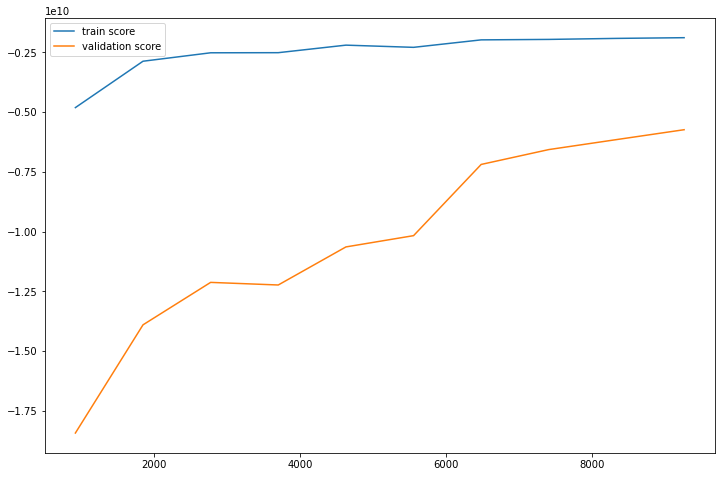

In [46]:
N, train_score, val_score = learning_curve(model_f, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

In [ ]:
#avec les donnees de 2017

In [84]:
preprocessor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_classif, k=7))
model_f = make_pipeline(preprocessor, RandomForestRegressor(random_state=0,n_estimators=90,max_features='sqrt',min_samples_split=3,max_depth=80, bootstrap='True' ) )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

70093.47618820249

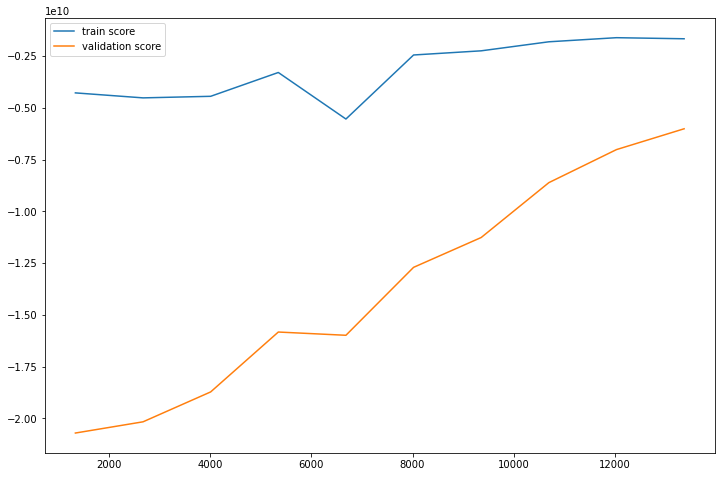

In [83]:
N, train_score, val_score = learning_curve(model_f, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

In [ ]:
#avec les donnees de 2020 

In [50]:
preprocessor = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_classif, k=7))
model_f = make_pipeline(preprocessor, RandomForestRegressor(random_state=0,n_estimators=90,max_features='sqrt',min_samples_split=3,max_depth=150, bootstrap='True' ) )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

97440.3491865793

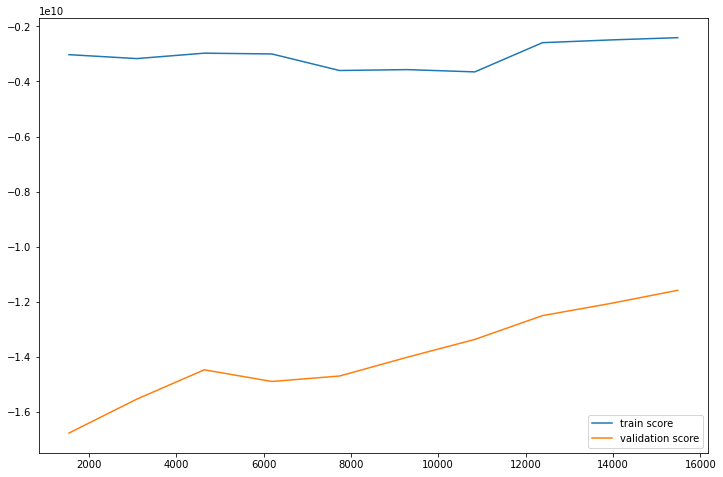

In [51]:
N, train_score, val_score = learning_curve(model_f, X_train, y_train,
                                              cv=4, scoring='neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

On veut regarder combien de valeurs sont correctement estimées (on va dire à 20k pres)

In [113]:
sum(abs(y_test[:100]-y_pred[:100]) < 20000) #sur 100 valeurs, 61 sont prédites à 20k pres

61

In [117]:
(sum(abs(y_test-y_pred) < 20000)/y_test.shape[0])*100 #58% des valeurs prédites à 20k pres

58.10196870267542

In [118]:
(sum(abs(y_test-y_pred) < 50000)/y_test.shape[0])*100 #77% des valeurs sont prédites à 50k pres

77.3346794548208

In [119]:
(sum(abs(y_test-y_pred) < 10000)/y_test.shape[0])*100 #45% des valeurs sont prédites à 10k pres

45.17920242301868

In [120]:
(sum(abs(y_test-y_pred) < 100000)/y_test.shape[0])*100 #90% des valeurs sont prédites à 100k pres

90.50984351337709

Même en filtrant les outliers on arrive pas à faire mieux sur notre modèle, donc on va essayer un autre modele 

In [521]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

132628.7871686199

In [522]:
from sklearn import decomposition, datasets

In [523]:

std_slc = StandardScaler()
pca = decomposition.PCA()

In [525]:
dec_tree = DecisionTreeRegressor()

In [528]:
pipe = make_pipeline(std_slc, pca, dec_tree)

In [561]:
preprocessor = make_pipeline(StandardScaler() )
model_f = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=0) )

model_f.fit(X_train, y_train)
y_pred = model_f.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

133071.20396033453

In [545]:
pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('pca', PCA()),
  ('decisiontreeregressor', DecisionTreeRegressor())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'pca': PCA(),
 'decisiontreeregressor': DecisionTreeRegressor(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'decisiontreeregressor__ccp_alpha': 0.0,
 'decisiontreeregressor__criterion': 'mse',
 'decisiontreeregressor__max_depth': None,
 'decisiontreeregressor__max_features': None,
 'decisiontreeregressor__max_leaf_nodes': None,
 'decisiontreeregressor__min_impurity_decrease': 0.0,
 'decisiontreeregressor__min_impurity_split': None,
 'decisiontreeregressor__min_samples_leaf': 1,
 'decisiontreeregressor__min_samples_split': 2,
 'decisiontreeregressor__min_weight_

In [1]:
plt.boxplot()

NameError: name 'plt' is not defined